In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import F1Score, Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import HeNormal

from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical

2024-06-07 00:13:43.363667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 00:13:43.363796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 00:13:43.512087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
df = pd.read_csv('/kaggle/input/bank-data/bank_data_train.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Data cleaning

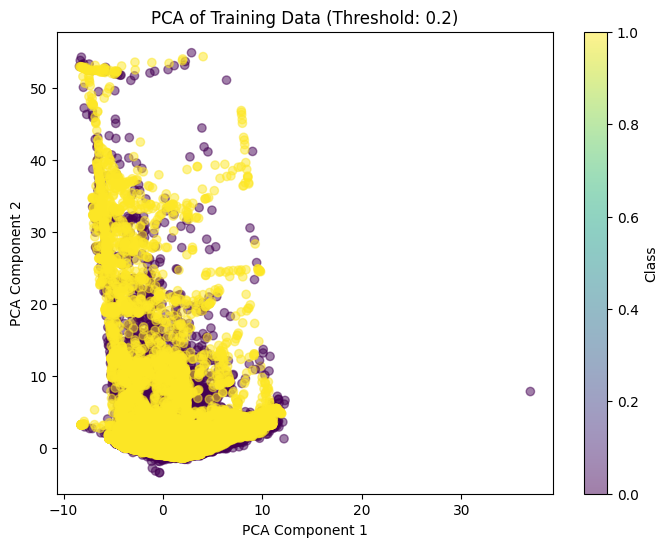

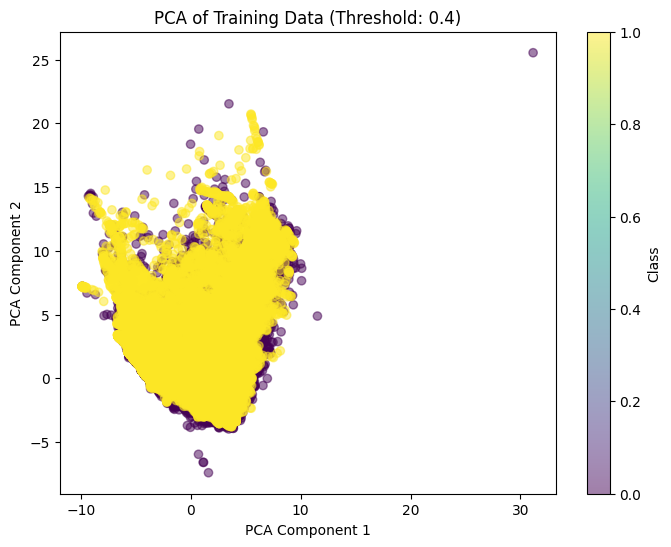

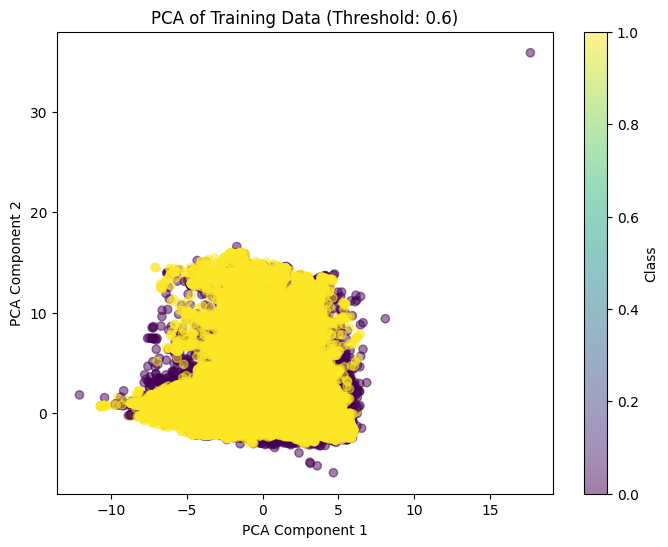

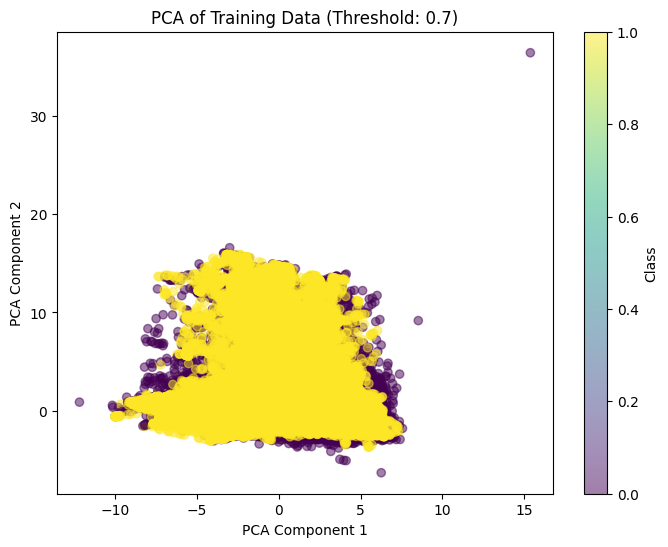

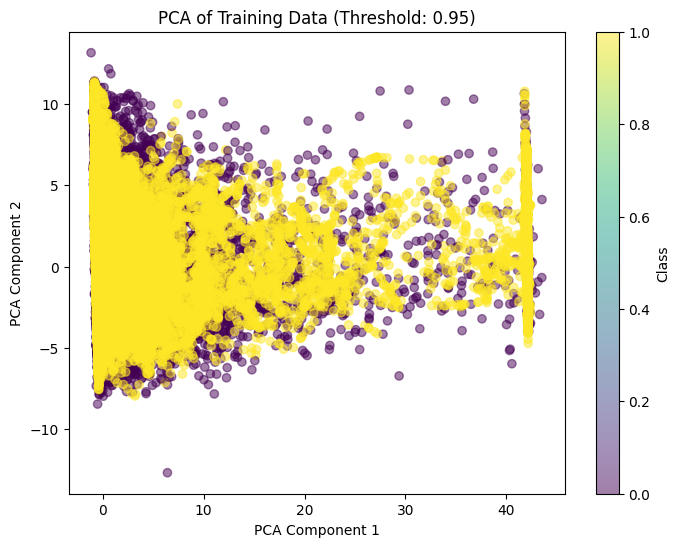

Threshold: 0.2, Number of Features: 53, PCA Variance Ratio: [0.13917944 0.09943034]
Threshold: 0.4, Number of Features: 55, PCA Variance Ratio: [0.14186851 0.1025728 ]
Threshold: 0.6, Number of Features: 61, PCA Variance Ratio: [0.15057812 0.10189912]
Threshold: 0.7, Number of Features: 67, PCA Variance Ratio: [0.14427127 0.09473152]
Threshold: 0.95, Number of Features: 166, PCA Variance Ratio: [0.12596585 0.10328315]


In [3]:
def preprocess_and_evaluate(df, missing_value_thresholds=[0.5], target_col='TARGET', id_col='ID', job_position_col='CLNT_JOB_POSITION'):
    results = {}

    for threshold in missing_value_thresholds:
        # Drop columns which max and min values are 0
        zero_cols = [col for col in df.columns if df[col].dtype != 'object' and df[col].max() == 0 and df[col].min() == 0]
        df.drop(zero_cols, axis=1, inplace=True)

        # Drop CLNT_JOB_POSITION
        if job_position_col in df.columns:
            df.drop(job_position_col, axis=1, inplace=True)

        # Drop columns with more than threshold% missing values
        data_cleaned = df.loc[:, df.isnull().mean() < threshold]

        # Identify features and target variable
        X = data_cleaned.drop(columns=[target_col, id_col])
        y = data_cleaned[target_col]

        feature_names = X.columns.tolist()

        # Identify numerical and categorical columns
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = X.select_dtypes(include=['object']).columns

        # Define preprocessing pipelines for numerical and categorical data
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        # Fit and transform the data
        X_preprocessed = preprocessor.fit_transform(X)

        # Split the data into training, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Convert the target variables to numpy arrays
        X_train_numpy = np.array(X_train).astype(np.float32)
        y_train_numpy = np.array(y_train).astype(np.float32)
        X_val_numpy = np.array(X_val).astype(np.float32)
        y_val_numpy = np.array(y_val).astype(np.float32)
        X_test_numpy = np.array(X_test).astype(np.float32)
        y_test_numpy = np.array(y_test).astype(np.float32)

        # Convert numerical labels to one-hot for fitting it to the model
        num_classes = len(np.unique(y_train))
        y_train_cat = to_categorical(y_train_numpy, num_classes=num_classes)
        y_val_cat = to_categorical(y_val_numpy, num_classes=num_classes)
        y_test_cat = to_categorical(y_test_numpy, num_classes=num_classes)

        # Apply PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_train_numpy)

        # Plot the PCA result
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_numpy, cmap='viridis', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title(f'PCA of Training Data (Threshold: {threshold})')
        plt.colorbar(scatter, label='Class')
        plt.show()

        # Store results
        results[threshold] = {
            'num_features': X_train_numpy.shape[1],
            'pca_variance_ratio': pca.explained_variance_ratio_,
        }
    
    return results

# Example usage:
thresholds = [0.2, 0.4, 0.6, 0.7, 0.95]  # Define your thresholds
results = preprocess_and_evaluate(df, missing_value_thresholds=thresholds)

for threshold, result in results.items():
    print(f'Threshold: {threshold}, Number of Features: {result["num_features"]}, PCA Variance Ratio: {result["pca_variance_ratio"]}')


### Overall Analysis:
**Increasing Thresholds:** As the threshold increases, more features are retained because columns with higher proportions of missing values are not discarded.
PCA Variance Ratio: The proportion of variance explained by the first two principal components tends to decrease slightly as more features are included. This is because additional features might introduce noise or less informative variance, which spreads the total variance over more components.

In [20]:
df = pd.read_csv('/kaggle/input/bank-data/bank_data_train.csv')

# drop columns which max and min values are 0
zero_cols = []
for col in df.columns:
    if df[col].dtype != 'object':
        if df[col].max() == 0 and df[col].min() == 0:
            zero_cols.append(col)
df.drop(zero_cols, axis=1, inplace=True)

# drop CLNT_JOB_POSITION
df.drop('CLNT_JOB_POSITION', axis=1, inplace=True)

# Set threshold for missing values
threshold = 1

# Drop columns with more than x% missing values
data_cleaned = df.loc[:, df.isnull().mean() < threshold]

# Identify features and target variable
X = data_cleaned.drop(columns=['TARGET', 'ID'])
y = data_cleaned['TARGET']

In [24]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
feature_names = X.columns.tolist()
X_test.to_csv('/kaggle/working/X_test.csv', index=False)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply simple imputer with median for numerical values and most_frequent for categorical values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessor to the X_train
X_train = preprocessor.fit_transform(X_train)

# Apply preprocessor to X_val and X_test
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Sample 10% of the dataset
X_train, _, y_train, _ = train_test_split(
    X_train, y_train, test_size=0.01, random_state=42
)

# number of dimensions in the training dataset
n_dims = X_train.shape[-1]
print(f'There are {n_dims} dimensions/features in our dataset')

input_dims = X_train.shape

# Ensure input_dims is not empty
assert input_dims is not None, "Input dimensions are not set properly"

print(f'The input dimensions for the model are: {input_dims}')

There are 181 dimensions/features in our dataset
The input dimensions for the model are: (316474, 181)


In [25]:
def visualize_performance(history, main_title, model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    y_val_pred_proba = model.predict(X_val)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    # Calculate ROC AUC for validation set
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    print(classification_report(y_val, y_val_pred))
    
    print(f"Training accuracy: {round(history.history['accuracy'][-1],3)}")
    print(f"Validation accuracy: {round(history.history['val_accuracy'][-1],3)}")
    print(f"Validation ROC AUC: {round(roc_auc_val,3)}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    fig.suptitle(main_title, fontsize=18)

    # Plot Training vs Validation Loss
    axes[0, 0].plot(history.history['loss'])
    axes[0, 0].plot(history.history['val_loss'])
    axes[0, 0].legend(['loss', 'val_loss'])
    axes[0, 0].grid(True)
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].set_xlabel('Number of Epochs')
    axes[0, 0].set_ylabel('Loss')

    # Plot Training vs Validation Accuracy
    axes[0, 1].plot(history.history['accuracy'])
    axes[0, 1].plot(history.history['val_accuracy'])
    axes[0, 1].legend(['accuracy', 'val_accuracy'])
    axes[0, 1].grid(True)
    axes[0, 1].set_title('Training vs Validation Accuracy')
    axes[0, 1].set_xlabel('Number of Epochs')
    axes[0, 1].set_ylabel('Accuracy')

    # Plot Training vs Validation F1 Score
    axes[0, 2].plot(history.history['f1_score'])
    axes[0, 2].plot(history.history['val_f1_score'])
    axes[0, 2].legend(['f1_score', 'val_f1_score'])
    axes[0, 2].grid(True)
    axes[0, 2].set_title('Training vs Validation F1 Score')
    axes[0, 2].set_xlabel('Number of Epochs')
    axes[0, 2].set_ylabel('F1 Score')

    # Calculate ROC AUC for training set
    y_train_pred_proba = model.predict(X_train)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Plot ROC AUC
    axes[1, 0].plot(fpr_train, tpr_train, label=f'Train ROC AUC = {roc_auc_train:.2f}')
    axes[1, 0].plot(fpr_val, tpr_val, label=f'Val ROC AUC = {roc_auc_val:.2f}')
    axes[1, 0].plot([0, 1], [0, 1], 'k--')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True)
    axes[1, 0].set_title('ROC AUC Curve')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')

    # Calculate and plot confusion matrix for training set
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    cm_train = confusion_matrix(y_train, y_train_pred)
    ConfusionMatrixDisplay(cm_train).plot(ax=axes[1, 1])
    axes[1, 1].set_title('Training Confusion Matrix')

    # Calculate and plot confusion matrix for validation set
    cm_val = confusion_matrix(y_val, y_val_pred)
    ConfusionMatrixDisplay(cm_val).plot(ax=axes[1, 2])
    axes[1, 2].set_title('Validation Confusion Matrix')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [26]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1)
callbacks = [early_stopping, reduce_lr]

# Convert y_train and y_val to numpy arrays and reshape
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)

# Compute class weights
y_train_flat = y_train.flatten()  # Ensure y_train is a 1D numpy array for computing class weights
unique_classes = np.unique(y_train_flat)
print(f"Unique classes in y_train: {unique_classes}")

class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_flat)
class_weights = dict(enumerate(class_weights))
print(f"Computed class weights: {class_weights}")

Unique classes in y_train: [0 1]
Computed class weights: {0: 0.5442803729959722, 1: 6.145842234046685}


In [27]:
def create_model(input_dims, droprate=None, initializer=HeNormal()):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dims[-1], kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(64, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(128, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(128, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))
       
    model.add(Dense(128, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))
        
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))
        
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))
        
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(128, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(64, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if droprate is not None:
        model.add(Dropout(droprate))

    model.add(Dense(1, kernel_initializer=initializer))
    model.add(Activation('sigmoid'))

    return model


In [15]:
import joblib

# Save the preprocessor
joblib.dump(preprocessor, '/kaggle/working/preprocessor.pkl')

['/kaggle/working/preprocessor.pkl']

In [34]:
X_train[0].shape

(181,)

Training model with 20 epochs, adam optimizer, and 0.4 dropout rate


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 32)             │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 260,865 (1019.00 KB)

 Trainable params: 257,985 (1007.75 KB)

 Non-trainable params: 2,880 (11.25 KB)

Training model with 20 epochs, 32 batch size, and adam optimizer
Epoch 1/20
9890/9890 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.5566 - f1_score: 0.1510 - loss: 0.7114 - val_accuracy: 0.8838 - val_f1_score: 0.1522 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 2/20
9890/9890 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.5803 - f1_score: 0.1496 - loss: 0.6268 - val_accuracy: 0.8176 - val_f1_score: 0.1522 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 3/20
9890/9890 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.6168 - f1_score: 0.1498 - loss: 0.6060 - val_accuracy: 0.8378 - val_f1_score: 0.1522 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 4/20
9890/9890 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.6083 - f1_score: 0.1494 - loss: 0.5906 - val_accuracy: 0.8161 - val_f1_score: 0.1522 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 5/20
9890/9890 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.6095 - f1_score: 0.1510 - loss: 0.5864 - val_accuracy: 0.8408 - val_f1_score: 

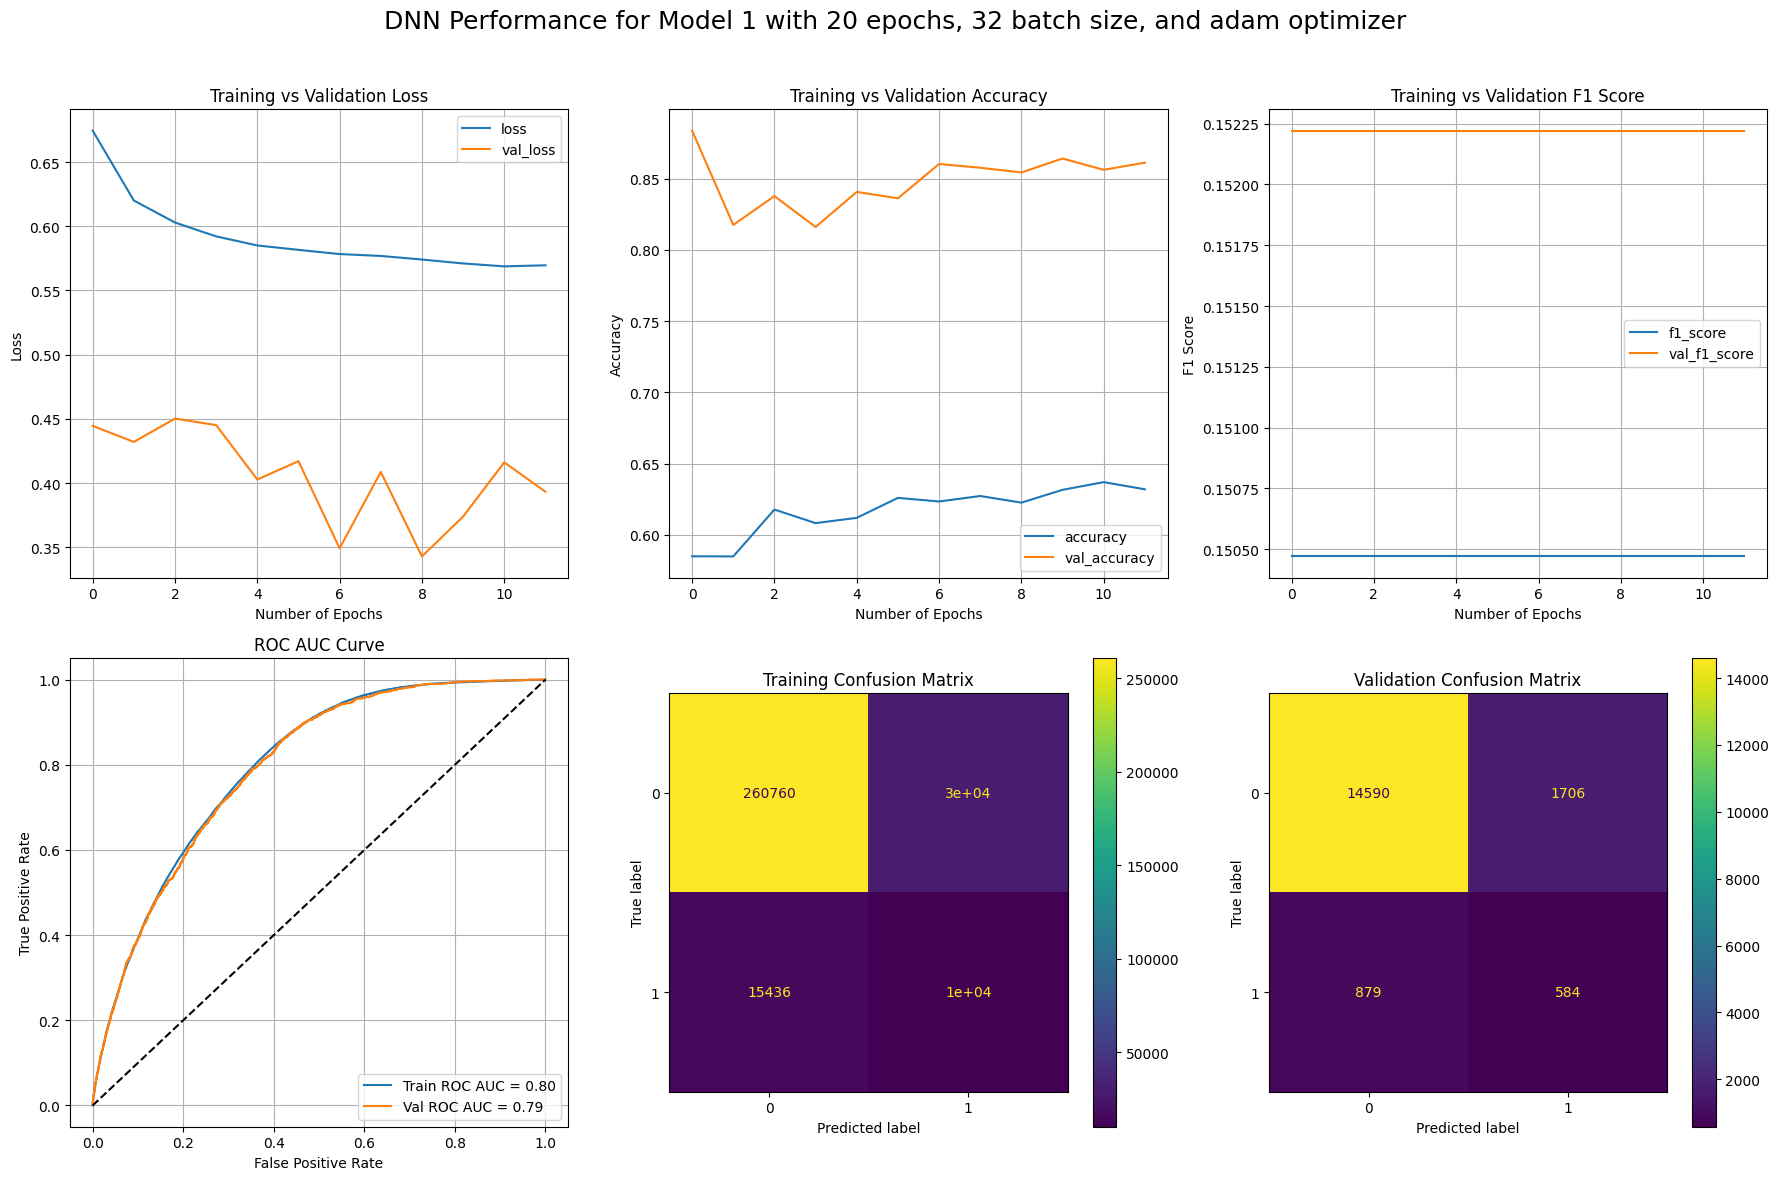

In [28]:
epochs = 20
batch_sizes = [32]
droprates = [0.4]
optimizers = ['adam']

for droprate in droprates:
    # Create model
    model = create_model(input_dims, droprate=droprate)

    for optimizer in optimizers:
        print("Training model with {} epochs, {} optimizer, and {} dropout rate".format(epochs, optimizer, droprate))
        model.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy', 'f1_score'],
                       )

        # Show the model summary
        model.summary()
        for batch_size in batch_sizes:
            print("Training model with {} epochs, {} batch size, and {} optimizer".format(epochs, batch_size, optimizer))
            history = model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                class_weight=class_weights

            )
            visualize_performance(history, f'DNN Performance for Model 1 with {epochs} epochs, {batch_size} batch size, and {optimizer} optimizer', model)